# STAT 596 Final Project

### TODO

In [1]:
# imports
import itertools
import numpy as np
import pandas as pd
from sklearn import preprocessing
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

# notebook settings
txt_color = "black"
InteractiveShell.ast_node_interactivity = "all"
figsize = (10,7)
sns.set_style("darkgrid", {'xtick.color':txt_color, 'ytick.color':txt_color})
sns.set_palette("PuBuGn_d")
%matplotlib inline

For this project we will only be considering the following fields: 
* Length - the span length of the bridge (inches)
* Width  - the total bridge width (inches)
* Skew - the skew angle of the bridge (degrees)
* Girder spacing - the spacing between brige girders (inches)
* Span-to-depth ratio - the ratio of span length to girder depth 

## Load and Transform Data

In [2]:
fields = pd.read_pickle('./data/fields.pickle') # data dictionary describing the fields
features = ["length", "width", "skew", "gdr_spacing", "span2depth"]
f = fields.loc[features]
f # descriptions of the fields we are interested in

,description
field,
length,Span Length
width,Total Bridge Width
skew,Bridge Skew
gdr_spacing,Girder Spacing
span2depth,Span to Depth Ratio


In [3]:
parameters = pd.read_pickle('./data/par2.pickle') # features
ratings = pd.read_pickle('./data/rtg2.pickle') # responses
demands = pd.read_pickle('./data/dem2.pickle') # responses
parameters.reset_index(drop=True, inplace=True)
ratings.reset_index(drop=True, inplace=True)
demands.reset_index(drop=True, inplace=True)

Extract the columns we are interested in.

In [4]:
p = parameters[features]
r = ratings[["slg_st1_pos", "fe_st1_pos"]]

In [5]:
r.head()

,slg_st1_pos,fe_st1_pos
0,"[2.158, 2.05]","[2.332, 2.66, 2.999, 2.988, 2.655, 2.324]"
1,"[3.127, 3.258]","[3.493, 3.306, 3.708, 3.931, 3.693, 3.353, 3.521]"
2,"[2.761, 2.686]","[2.833, 3.562, 4.293, 3.792, 2.942]"
3,"[3.845, 3.376]","[4.569, 5.068, 5.671, 6.115, 6.599, 7.063, 7.2..."
4,"[1.91, 1.814]","[2.215, 2.526, 2.82, 2.96, 2.821, 2.493, 2.234]"


Flatten cells of dataframe to get minimum rating values for interior and exterior girders.

In [6]:
slg_int = lambda x: x[0]
fe_int = lambda x: min(x[1:-1])
rr = pd.DataFrame({"slg_int_pos": r.slg_st1_pos.apply(slg_int),
                   "fe_int_pos": r.fe_st1_pos.apply(fe_int)})
rr.head()

,slg_int_pos,fe_int_pos
0,2.158,2.655
1,3.127,3.306
2,2.761,3.562
3,3.845,5.068
4,1.910,2.493


## Data Exploration

#### Is there a statistically significant difference between fe and slg responses?

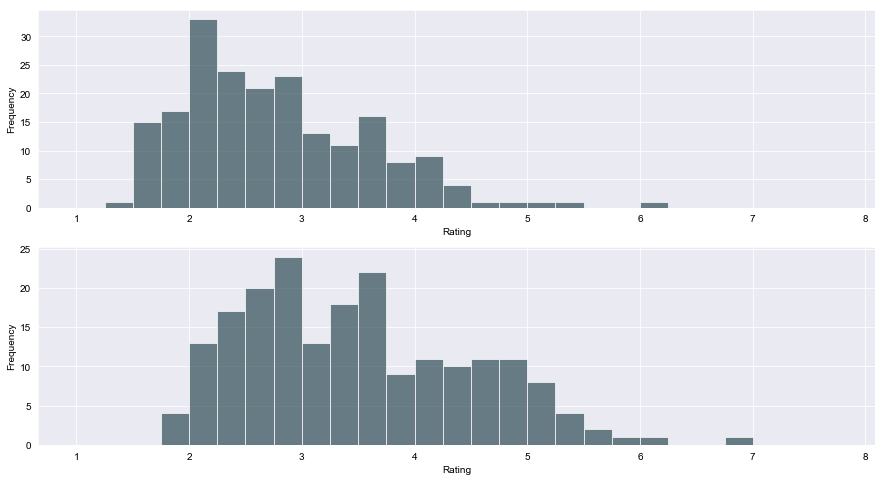

In [7]:
fig, ax = plt.subplots(2,1, figsize=(15,8));
ax[0].set_xlabel("Rating", color=txt_color); 
ax[0].set_ylabel("Frequency", color=txt_color); 
ax[0].hist(rr.slg_int_pos, bins=np.arange(1,8,0.25), alpha=0.7, label="Interior");
ax[1].set_xlabel("Rating", color=txt_color); 
ax[1].set_ylabel("Frequency", color=txt_color);
ax[1].hist(rr.fe_int_pos, bins=np.arange(1,8,0.25), alpha=0.7, label="Interior");

The distributions shown in the plots above suggest that some of the data may follow a non-normal distribution. Moreover, the center of the distributions for model 2 (the second row) appears be larger than the center of the distributions for model 1 (the first row). This becomes even more evident when we compare the sample mean and median. Both are greater for model 2.

In [8]:
rr.describe()

,slg_int_pos,fe_int_pos
count,200.000000,200.000000
mean,2.773615,3.496970
std,0.829014,1.006366
min,1.426000,1.777000
25%,2.142500,2.667000
50%,2.637000,3.375000
75%,3.325500,4.183500
max,6.064000,6.975000


To test that FE ratings are indeed larger, we will use a non-parametric method. We have decided to use a non-parametric method because of the skew we observe in the data distribution. Moreover, for this data, it is known that the rating values have a strict lower bound of 1.0 and in some extreme cases (such as the distribution we see in the top right corer) the center of the data can approach 1.0.

Our null hypothesis that the population median of  bridge ratings is equal for both models. With an alpha value of 0.01, we can reject the null hypothesis, in favor of the alternative. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

In [9]:
stats.kruskal(rr.slg_int_pos, rr.fe_int_pos)

KruskalResult(statistic=53.54495838214616, pvalue=2.527421917892732e-13)

The results of the Kruskal-Wallis test tell us that there is significant evidence suggesting that the medians for each model are different. 

Explain why this matters...

Conservatism in design can be captured by the DIFFERENCE of FE to SLG ratings. A ratio greater than 1 suggests that the design was inherently conservative. A ratio less than 1 suggests the design may be unconcervative and the bridge may potentially be underdesigned.

In [10]:
diff = rr.fe_int_pos-rr.slg_int_pos
diff.describe()

count    200.000000
mean       0.723355
std        0.310335
min       -0.066000
25%        0.535500
50%        0.681500
75%        0.860750
max        2.274000
dtype: float64

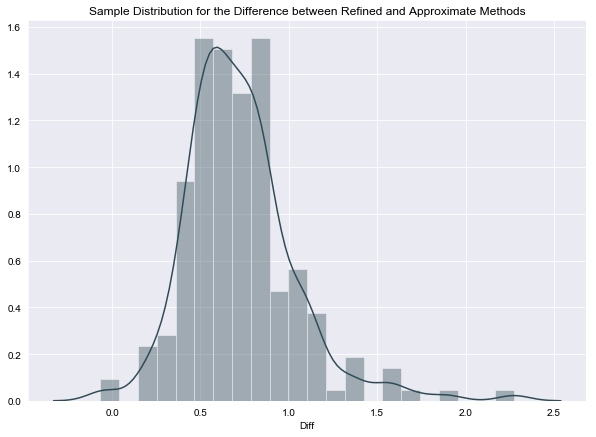

In [35]:
fig, ax = plt.subplots(figsize=figsize)
sns.distplot(diff, ax=ax)
ax.set_xlabel("Diff", color=txt_color);
ax.set_title("Sample Distribution for the Difference between Refined and Approximate Methods", color=txt_color);

We would like to determine which parameters influence conservatism in design. Let us first plot our features against the ratios.

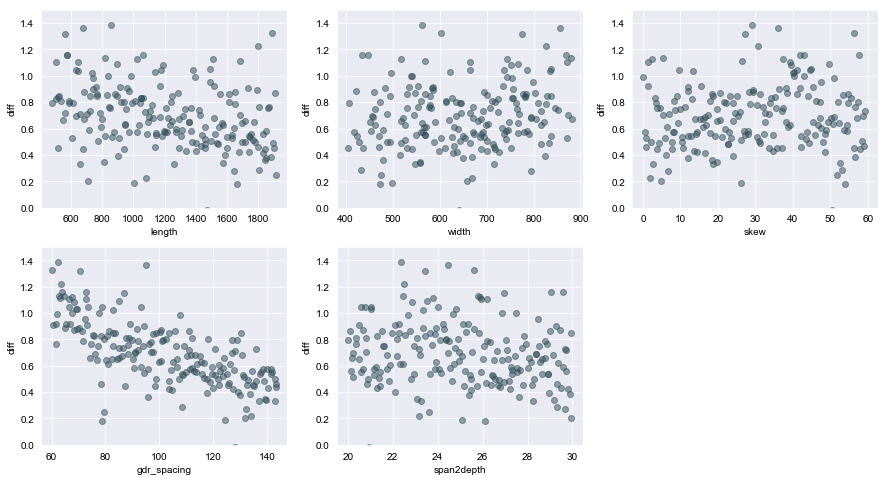

In [12]:
q = p.columns.values.tolist()[::-1]
fig, ax = plt.subplots(2,3, figsize=(15,8));
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if q:
            x = q.pop()
            _ = ax[i,j].scatter(p[x],diff, alpha=0.5);
            _ = ax[i,j].set_xlabel(x, color=txt_color);
            _ = ax[i,j].set_ylabel('diff', color=txt_color);
            _ = ax[i,j].set_ylim(0,1.5)
        else:
            _ = ax[i,j].axis('off');

## Modeling

In [13]:
import statsmodels.api as sm # import statsmodels 
import statsmodels.graphics.gofplots as smg
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [14]:
def fitlm(y, X, intercept=True, scale=False, summary=True):
    
    if scale:
        scale = lambda x: (preprocessing.MinMaxScaler().fit_transform(x.values) 
                   if len(x.shape) > 1 
                   else preprocessing.MinMaxScaler().fit_transform(x.values.reshape(-1,1))
                  )
        X = pd.DataFrame(scale(X), columns=X.columns)
    
    if intercept: # add an intercept to the model
        X = sm.add_constant(X) 

    model = sm.OLS(y, X).fit()
    
    if summary: # Print out the statistics
        print(model.summary())
        print()         
        
    return model

def model_diagnostics(model):
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
        
    # residuals plot
    _ = sns.residplot(model.fittedvalues, model.resid, ax=ax[0],
                      lowess=True, 
                      scatter_kws={'alpha': 0.5}, 
                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    ax[0].set_title('Residuals vs Fitted', color=txt_color)
    ax[0].set_xlabel('Fitted values', color=txt_color)
    ax[0].set_ylabel('Residuals', color=txt_color)
    # annotations
    abs_resid = np.abs(model.resid).sort_values(ascending=False)[:5]
    for i in abs_resid.index:
        ax[0].annotate(i, xy=(model.fittedvalues[i], model.resid[i]));

    # QQ Plot
    QQ = smg.ProbPlot(model.resid)
    _ = QQ.qqplot(line='q', alpha=0.5, color='#4C72B0', lw=1, ax=ax[1])
    ax[1].set_title('Q-Q Plot', color=txt_color)
    ax[1].set_xlabel('Theoretical Quantiles', color=txt_color)
    ax[1].set_ylabel('Sample Quantiles', color=txt_color);      
    # annotations
    abs_resid = np.flip(np.argsort(np.abs(model.resid)), 0)[:5]
    theoretical_quantiles = QQ.theoretical_quantiles.tolist()
    sample_quantiles = QQ.sample_quantiles.tolist()
    for idx in abs_resid.index:
        ax[1].annotate(abs_resid.loc[idx], xy=(theoretical_quantiles.pop(), sample_quantiles.pop()));


    fig, ax = plt.subplots(1,2, figsize=(15,5))

    # Leverage
    fig = plot_leverage_resid2(model, ax = ax[0])
#     _ = sm.graphics.influence_plot(model, ax=ax[0], plot_alpha=0.5, size=5)
    ax[0].xaxis.label.set_color(txt_color)
    ax[0].yaxis.label.set_color(txt_color)
    ax[0].title.set_color(txt_color)
#     ax[0].title.set_fontsize(12)
#     ax[0].xaxis.label.set_fontsize(10)
#     ax[0].yaxis.label.set_fontsize(10)

    # Influence plot
    QQ = smg.ProbPlot(model.resid)
    influence = model.get_influence().summary_frame()
    theoretical_quantiles = QQ.theoretical_quantiles.tolist()
    ax[1].scatter(theoretical_quantiles, np.array(sorted(influence.cooks_d)), alpha=0.5)
    cooks = np.flip(np.argsort(np.abs(influence.cooks_d)), 0)[:5]
    for idx in cooks.index:
        ax[1].annotate(cooks.loc[idx], xy=(theoretical_quantiles.pop(), influence.cooks_d.iloc[cooks.loc[idx]]));
    ax[1].set_title('Influence', color=txt_color)
    ax[1].set_xlabel('Half-Normal Quantiles', color=txt_color)
    ax[1].set_ylabel("Cooks's Distance", color=txt_color);
    ax[1].set_xlim(0,np.ceil(max(theoretical_quantiles))+1)
    
    print(f"Shapiro-Wilk Test for Normality of REsiduals: {stats.shapiro(model.resid)}")

def forward_selection(y, X):
    
    remaining = set(X.columns)
    selected = []
    Xtemp = X
    score = fitlm(y, np.ones(len(y)), summary=False).bic
    current_score, best_new_score = score, score
    
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            Xtemp = X[selected + [candidate]]
            score = fitlm(y, Xtemp, summary=False).bic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        scores_with_candidates.reverse()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            
    model = fitlm(y, X[selected], summary=True)
    return model

def exhaustive_search(y, X):
    X = sm.add_constant(X)
    lr = LinearRegression()
    efs = EFS(lr, 
              min_features=1,
              max_features=5,
              scoring='r2',
              cv=10);
    efs.fit(X, y);
    best_features = [f for f in efs.best_feature_names_]
    model = fitlm(y, X[best_features], summary=True)
    return model

scale = lambda x: (preprocessing.MinMaxScaler().fit_transform(x.values) 
                   if len(x.shape) > 1 
                   else preprocessing.MinMaxScaler().fit_transform(x.values.reshape(-1,1))
                  )

### Simple Model (Only 5 Features, No Interactions or Polynomials)

In [49]:
y = diff
X = parameters[["length", "width", "skew", "gdr_spacing", "span2depth", "t_deck", "intgdr_Ix", "intgdr_dfm"]]
# scale X
# X = np.log(X)
X_scaled = pd.DataFrame(scale(X), columns=X.columns)
# scale y
y_scaled = pd.DataFrame(scale(y), columns=[y.name])

Features: 381/381

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     28.89
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           7.53e-22
Time:                        17:24:41   Log-Likelihood:                 176.41
No. Observations:                 200   AIC:                            -340.8
Df Residuals:                     194   BIC:                            -321.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4875      0.030     16.287      

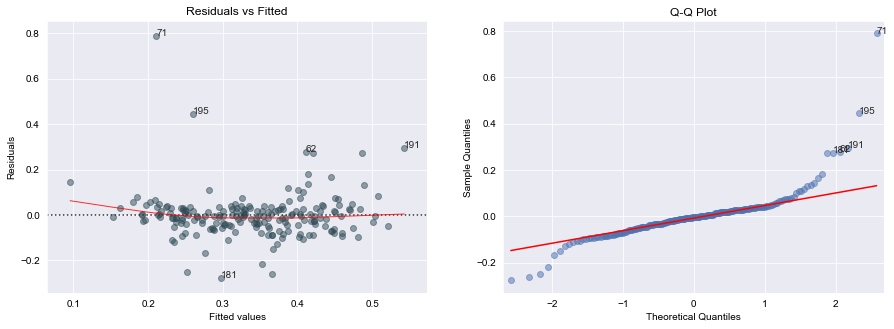

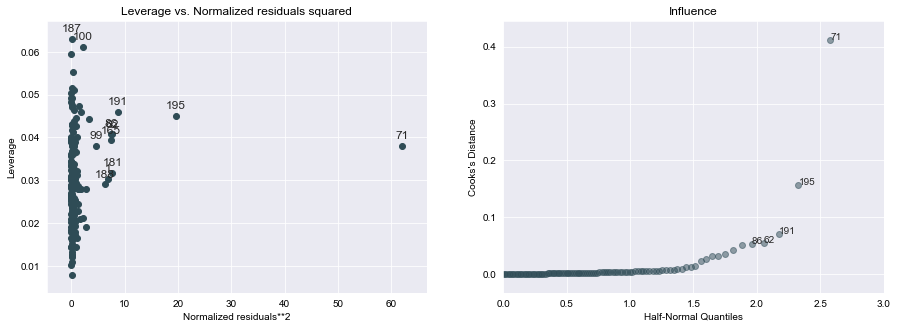

In [50]:
model = exhaustive_search(y_scaled, X_scaled)
model_diagnostics(model)

Observe data point 71 may be an outlier. Perform outlier test using Bonferroni-corrected rejection criteria.

In [51]:
model.outlier_test(order=True)[:5]

,student_resid,unadj_p,bonf(p)
71,9.587996,4.718222e-18,9.436444e-16
195,4.700678,4.923582e-06,9.847163e-04
191,3.041190,2.683919e-03,5.367838e-01
62,2.833568,5.092470e-03,1.000000e+00
181,-2.818780,5.323165e-03,1.000000e+00


It appears we may have two outliers: 71, and 195. Let's take a closer look at these outliers.

In [52]:
X.loc[[71, 195]]
X.describe()
y.loc[[71, 195]]

,length,width,skew,gdr_spacing,span2depth,t_deck,intgdr_Ix,intgdr_dfm
71,1328.802269,423.286530,29.203925,141.095510,22.630482,8.859116,57178.468801,0.826363
195,1393.947049,825.608394,55.329276,137.601399,27.799826,8.029556,50783.110808,0.688688


,length,width,skew,gdr_spacing,span2depth,t_deck,intgdr_Ix,intgdr_dfm
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1199.955912,645.341407,29.972438,102.002081,25.000250,8.249967,49675.060997,0.634071
std,416.812185,126.755141,17.365957,24.289789,2.894515,0.434305,41624.210151,0.113800
min,481.417343,404.606504,0.097457,60.289081,20.009091,7.501368,1874.367688,0.399544
25%,844.302186,545.452214,15.088922,80.951768,22.487769,7.875812,14776.110149,0.539365
50%,1200.418353,645.039369,29.974186,101.890599,25.015227,8.248364,37802.208985,0.623888
75%,1559.816839,752.391463,45.019839,122.921475,27.495517,8.623401,81140.939803,0.716875
max,1914.250065,881.039643,59.738135,143.449639,29.949670,8.999755,215270.196535,0.874455


71     2.274
195    1.581
dtype: float64

Comparing samples 71 and 195 to the rest of the data, we see that both of these samples are approaching the upper bound of girder spacing. One thing that sticks out about sample 71 is the ratio of width to girder spacing. Sample 71 is on the lower bound of bridge width, and at the uppper bound of girder spacing. This means that this sample has the minimal number of girders allowed (4). Lets drop sample 71 and see how it affects our model.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     58.81
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           6.47e-37
Time:                        17:25:22   Log-Likelihood:                 228.41
No. Observations:                 198   AIC:                            -444.8
Df Residuals:                     192   BIC:                            -425.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4967      0.023     21.422      

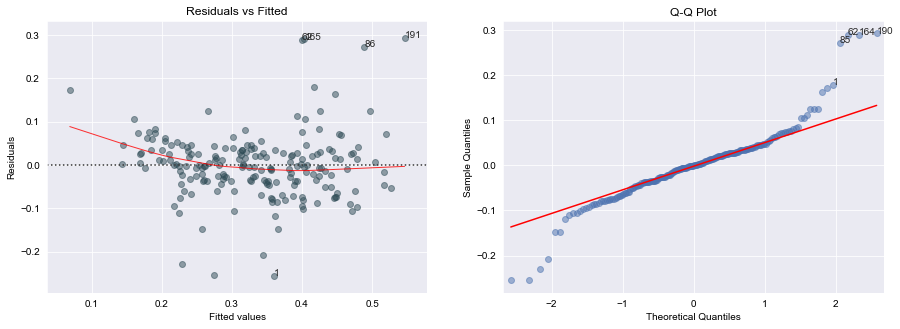

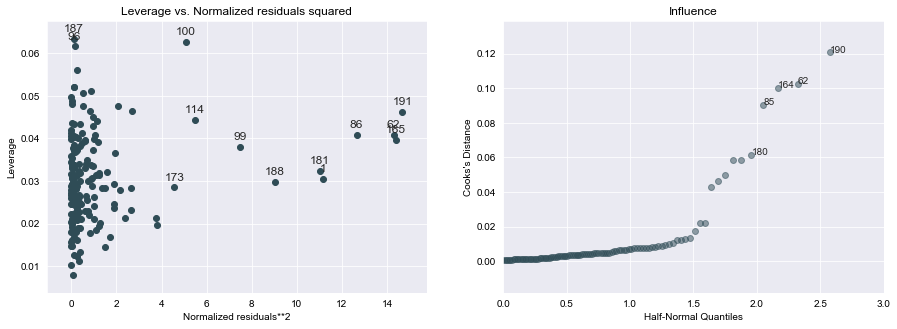

In [54]:
# drop outliers and recompute estimates
params = model.params.index
Xnew = X_scaled[params[1:]].drop([71,195], axis=0)
ynew = y_scaled.drop([71,195], axis=0)
model = fitlm(ynew, Xnew)
model_diagnostics(model)

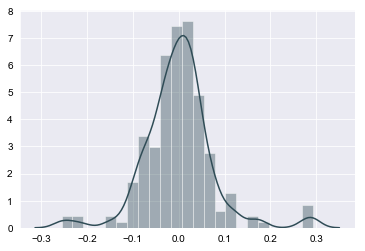

In [56]:
sns.distplot(model.resid)

#### Check for multicollinearity.

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
x1 = sm.add_constant(Xnew[params[1:]])
pd.Series([variance_inflation_factor(x1.values, i) 
               for i in range(x1.shape[1])], 
              index=x1.columns)

const          17.710470
length          1.012103
width           1.042045
skew            1.046789
gdr_spacing     1.002800
span2depth      1.012799
dtype: float64

#### Plots of Residuals vs Predictors

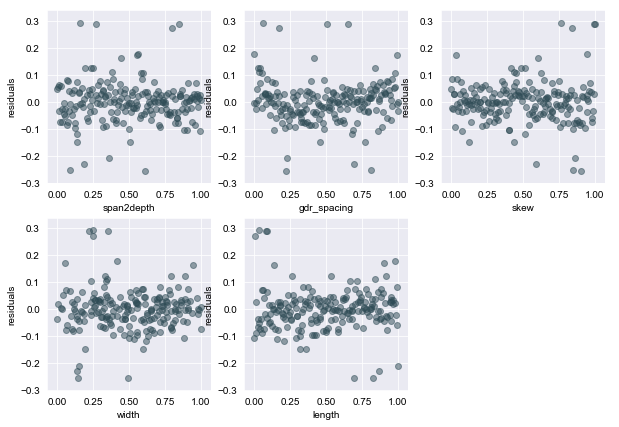

In [58]:
q = model.params.index.tolist()[1:]
fig, ax = plt.subplots(int(np.ceil(len(q)/3)),3, figsize=figsize)
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if q:
            x = q.pop()
            _ = ax[i,j].scatter(Xnew[x],model.resid, alpha=0.5);
            _ = ax[i,j].set_xlabel(x, color=txt_color);
            _ = ax[i,j].set_ylabel('residuals', color=txt_color);
        else:
            _ = ax[i,j].axis('off');

Partial Residual Plots

### Model With Interactions and Polynomial Terms

In [66]:
y = diff
X = parameters[["length", "width", "skew", "gdr_spacing", "span2depth", "t_deck", "intgdr_Ix", "intgdr_dfm"]]

In [67]:
poly = preprocessing.PolynomialFeatures(interaction_only=True, include_bias = False)
columns = poly.fit(X).get_feature_names(X.columns)
X = pd.DataFrame(poly.fit_transform(X), columns=columns)
columns
# scale X
X_scaled = pd.DataFrame(scale(X), columns=X.columns)
# scale y
y_scaled = pd.DataFrame(scale(y), columns=[y.name])

['length',
 'width',
 'skew',
 'gdr_spacing',
 'span2depth',
 't_deck',
 'intgdr_Ix',
 'intgdr_dfm',
 'length width',
 'length skew',
 'length gdr_spacing',
 'length span2depth',
 'length t_deck',
 'length intgdr_Ix',
 'length intgdr_dfm',
 'width skew',
 'width gdr_spacing',
 'width span2depth',
 'width t_deck',
 'width intgdr_Ix',
 'width intgdr_dfm',
 'skew gdr_spacing',
 'skew span2depth',
 'skew t_deck',
 'skew intgdr_Ix',
 'skew intgdr_dfm',
 'gdr_spacing span2depth',
 'gdr_spacing t_deck',
 'gdr_spacing intgdr_Ix',
 'gdr_spacing intgdr_dfm',
 'span2depth t_deck',
 'span2depth intgdr_Ix',
 'span2depth intgdr_dfm',
 't_deck intgdr_Ix',
 't_deck intgdr_dfm',
 'intgdr_Ix intgdr_dfm']

In [ ]:
model = exhaustive_search(y_scaled, X_scaled)
model_diagnostics(model)

In [ ]:
sns.distplot(model.resid)

In [ ]:
model.outlier_test(order=True)[:5]

In [ ]:
q = model.params.index.tolist()[1:]
fig, ax = plt.subplots(int(np.ceil(len(q)/3)),3, figsize=figsize)
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if q:
            x = q.pop()
            _ = ax[i,j].scatter(X[x],model.resid, alpha=0.5);
            _ = ax[i,j].set_xlabel(x, color=txt_color);
            _ = ax[i,j].set_ylabel('residuals', color=txt_color);
        else:
            _ = ax[i,j].axis('off');

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     59.49
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           3.34e-37
Time:                        16:48:44   Log-Likelihood:                 229.10
No. Observations:                 198   AIC:                            -446.2
Df Residuals:                     192   BIC:                            -426.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4603      0.01

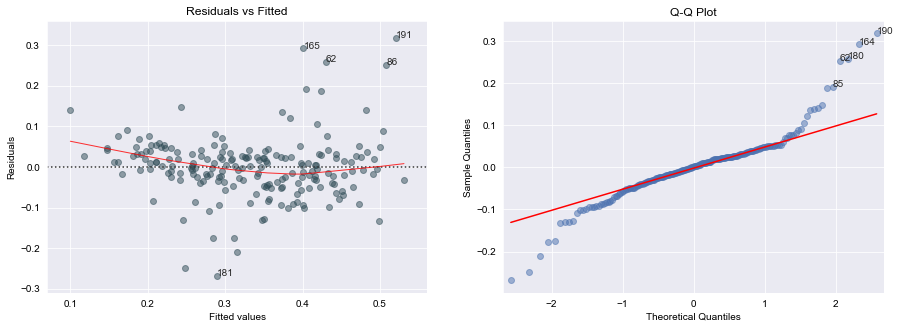

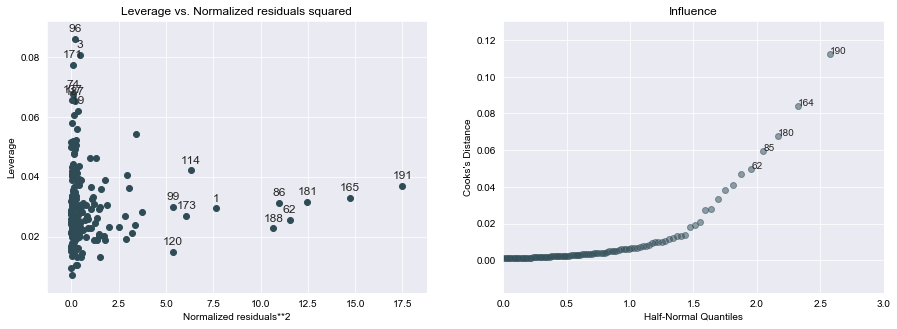

In [30]:
params = model.params.index
Xnew = X_scaled[params[1:]].drop([71, 195], axis=0)
ynew = y_scaled.drop([71, 195], axis=0)
model = fitlm(ynew, Xnew)
model_diagnostics(model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     32.48
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           5.46e-24
Time:                        16:48:46   Log-Likelihood:                 181.59
No. Observations:                 200   AIC:                            -351.2
Df Residuals:                     194   BIC:                            -331.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

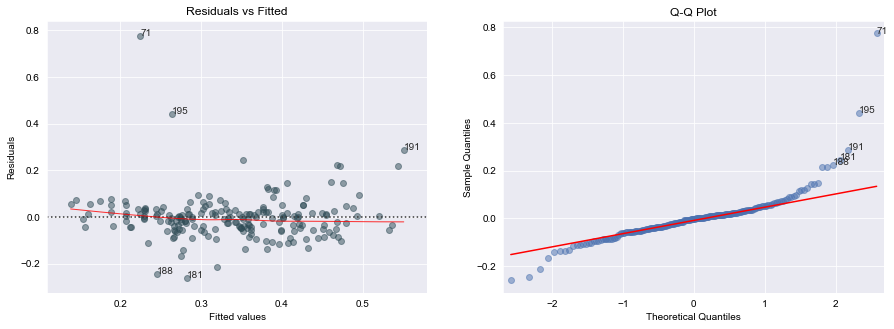

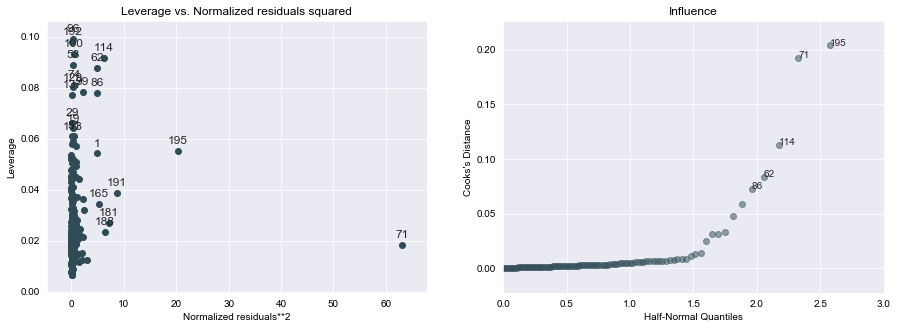

In [31]:
model = forward_selection(y_scaled, X_scaled)
model_diagnostics(model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     65.03
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           1.78e-39
Time:                        16:48:46   Log-Likelihood:                 234.55
No. Observations:                 198   AIC:                            -457.1
Df Residuals:                     192   BIC:                            -437.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

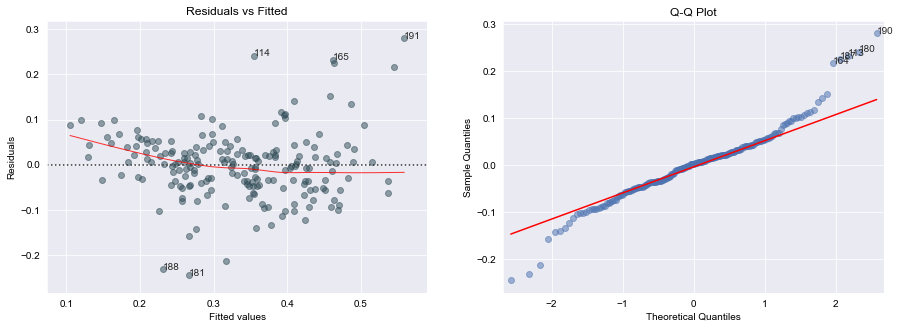

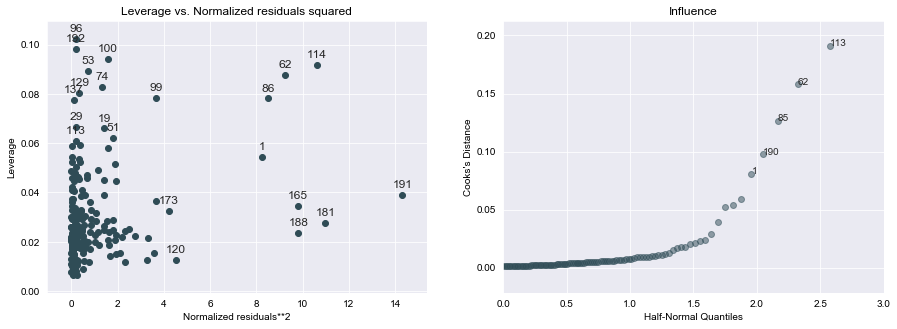

In [32]:
params = model.params.index
Xnew = X[params[1:]].drop([71, 195], axis=0)
ynew = y.drop([71, 195], axis=0)
model = fitlm(ynew, Xnew)
model_diagnostics(model)

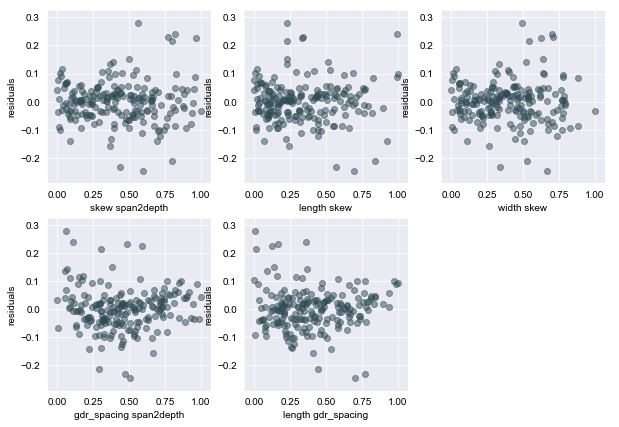

In [33]:
q = model.params.index.tolist()[1:]
fig, ax = plt.subplots(int(np.ceil(len(q)/3)),3, figsize=figsize)
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if q:
            x = q.pop()
            _ = ax[i,j].scatter(Xnew[x],model.resid, alpha=0.5);
            _ = ax[i,j].set_xlabel(x, color=txt_color);
            _ = ax[i,j].set_ylabel('residuals', color=txt_color);
        else:
            _ = ax[i,j].axis('off');